# Test of decision tree regressor with multi-output

In [44]:
import sys
import os
workspace_path = os.path.join(os.path.abspath(".."))
sys.path.append(workspace_path)
workspace_path

'c:\\Users\\Kajsa\\VSCodeProjects\\job_discrimination_sandbox'

In [45]:
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
import warnings
warnings.simplefilter("ignore")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Local imports
from src.helpers import *

In [46]:
pd.options.display.float_format = "{:.2f}".format

In [47]:
path_to_cleaned_data = os.path.join(workspace_path, "data", "cleaned_data")

In [48]:
# Reading application statistics into dataframe
file_path = os.path.join(path_to_cleaned_data, "bulletins_w_labels_and_content.csv")
df = pd.read_csv(file_path, dtype={"ID": str})

In [49]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label 60/40,Numeric label 60/40,Label 70/30,Numeric label 70/30,Cleaned text,Text
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,2,N,0,director class code open date annual salary du...,311 DIRECTOR Class Code: 9206 Open Date:...
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,1,W,1,accounting clerk class code open date exam ope...,ACCOUNTING CLERK Class Code: 1223 Open ...
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,2,M,2,airport manager class code open date exam open...,AIRPORT MANAGER Class Code: 7260 Open D...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,2,M,2,airport police lieutenant class code open date...,AIRPORT POLICE LIEUTENANT ...
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,2,N,0,aquarist class code open date annual salary ca...,AQUARIST Class Code: 2400 Open Date: 05...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,2,N,0,wastewater treatment laboratory manager class ...,WASTEWATER TREATMENT LABORATORY MANAGER Class...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,2,M,2,wastewater treatment operator class code open ...,WASTEWATER TREATMENT OPERATOR Class Code: ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,0,N,0,water microbiologist class code open date revi...,WATER MICROBIOLOGIST Class Code: 7857...
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,2,M,2,water utility worker class code open date exam...,WATER UTILITY WORKER Class Code: 3912 Op...


In [50]:
df.drop(columns=["Label 60/40", "Numeric label 60/40", "Label 70/30", "Numeric label 70/30", "Text", "File Names"], inplace=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               177 non-null    object
 1   Job Description  177 non-null    object
 2   Apps Received    177 non-null    int64 
 3   Female           177 non-null    int64 
 4   Male             177 non-null    int64 
 5   Unknown_Gender   177 non-null    int64 
 6   Cleaned text     177 non-null    object
dtypes: int64(4), object(3)
memory usage: 9.8+ KB


In [52]:
df["Male share"] = df["Male"] / df["Apps Received"]
df["Female share"] = df["Female"] / df["Apps Received"]
df["Unknown share"] = df["Unknown_Gender"] / df["Apps Received"]

In [53]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,Cleaned text,Male share,Female share,Unknown share
0,9206,311 DIRECTOR,54,20,31,3,director class code open date annual salary du...,0.57,0.37,0.06
1,1223,ACCOUNTING CLERK,648,488,152,8,accounting clerk class code open date exam ope...,0.23,0.75,0.01
2,7260,AIRPORT MANAGER,51,13,37,1,airport manager class code open date exam open...,0.73,0.25,0.02
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,airport police lieutenant class code open date...,0.79,0.19,0.02
4,2400,AQUARIST,40,15,24,1,aquarist class code open date annual salary ca...,0.60,0.38,0.03
...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,wastewater treatment laboratory manager class ...,0.56,0.38,0.06
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,wastewater treatment operator class code open ...,0.90,0.07,0.02
174,7857,WATER MICROBIOLOGIST,179,89,82,8,water microbiologist class code open date revi...,0.46,0.50,0.04
175,3912,WATER UTILITY WORKER,96,2,92,2,water utility worker class code open date exam...,0.96,0.02,0.02


In [54]:
X = df["Cleaned text"]
y = df[["Male share", "Female share", "Unknown share"]]

In [55]:
# Initializing a vectorizer in order to transform the text to numbers

vect = TfidfVectorizer()

In [56]:
# Transforming X to tf-idf-vectors
X = vect.fit_transform(X).todense()

In [57]:
X.shape

(177, 3835)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

## Initializing model, training and prediction

In [59]:
model = DecisionTreeRegressor(max_depth=4)

In [60]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [61]:
y_pred = model.predict(X_test)

## Investigate results

In [62]:
y_pred

array([[0.95800667, 0.02547363, 0.0165197 ],
       [0.71119521, 0.26291233, 0.02589246],
       [0.95800667, 0.02547363, 0.0165197 ],
       [0.95800667, 0.02547363, 0.0165197 ],
       [0.44156687, 0.53625842, 0.02217471],
       [0.95800667, 0.02547363, 0.0165197 ],
       [0.37210113, 0.59414162, 0.03375726],
       [0.95800667, 0.02547363, 0.0165197 ],
       [0.44156687, 0.53625842, 0.02217471],
       [0.71119521, 0.26291233, 0.02589246],
       [0.44156687, 0.53625842, 0.02217471],
       [0.66346154, 0.32692308, 0.00961538],
       [0.50075887, 0.47559649, 0.02364464],
       [0.71119521, 0.26291233, 0.02589246],
       [0.71119521, 0.26291233, 0.02589246],
       [0.95800667, 0.02547363, 0.0165197 ],
       [0.71119521, 0.26291233, 0.02589246],
       [0.71119521, 0.26291233, 0.02589246],
       [0.50075887, 0.47559649, 0.02364464],
       [0.95800667, 0.02547363, 0.0165197 ],
       [0.71119521, 0.26291233, 0.02589246],
       [0.93033811, 0.04798318, 0.02167871],
       [0.

In [63]:
# Checking if predictions sum to 1, as expected
for line in y_pred:
    print(sum(line))

0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0
1.0


In [64]:
resultsdf = y_test

resultsdf["Pred Male share"] = [line[0] for line in y_pred]
resultsdf["Pred Female share"] = [line[1] for line in y_pred]
resultsdf["Pred Unknown share"] = [line[2] for line in y_pred]

In [65]:
resultsdf[resultsdf["Pred Male share"] < 0.6]

,Male share,Female share,Unknown share,Pred Male share,Pred Female share,Pred Unknown share
147,0.52,0.45,0.03,0.44,0.54,0.02
64,0.31,0.68,0.02,0.37,0.59,0.03
101,0.50,0.49,0.01,0.44,0.54,0.02
57,0.72,0.24,0.04,0.44,0.54,0.02
174,0.46,0.50,0.04,0.50,0.48,0.02
16,0.10,0.90,0.00,0.50,0.48,0.02
118,0.41,0.56,0.03,0.37,0.59,0.03
91,0.85,0.09,0.06,0.50,0.48,0.02
39,0.82,0.15,0.03,0.50,0.48,0.02
24,0.88,0.07,0.06,0.50,0.48,0.02


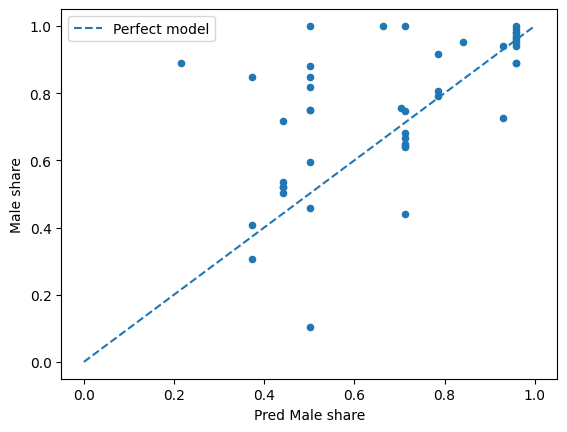

In [66]:
fig, ax = plt.subplots()
resultsdf.plot(kind="scatter", y="Male share", x="Pred Male share", ax=ax)
ax.plot([0, 1], [0, 1], "--", label="Perfect model")
ax.legend()
plt.show()

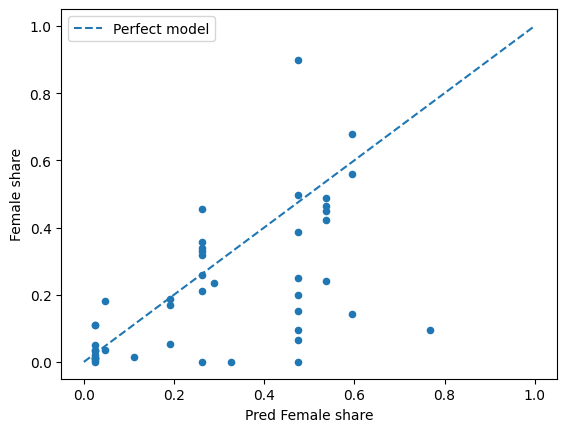

In [67]:
fig, ax = plt.subplots()
resultsdf.plot(kind="scatter", y="Female share", x="Pred Female share", ax=ax)
ax.plot([0, 1], [0, 1], "--", label="Perfect model")
ax.legend()
plt.show()

In [68]:
resultsdf.describe()

,Male share,Female share,Unknown share,Pred Male share,Pred Female share,Pred Unknown share
count,45.00,45.00,45.00,45.00,45.00,45.00
mean,0.76,0.21,0.02,0.68,0.30,0.02
std,0.21,0.21,0.02,0.22,0.22,0.01
min,0.10,0.00,0.00,0.22,0.03,0.01
25%,0.64,0.04,0.00,0.50,0.05,0.02
50%,0.81,0.17,0.02,0.71,0.26,0.02
75%,0.95,0.34,0.03,0.93,0.48,0.03
max,1.00,0.90,0.10,0.96,0.77,0.05


##### Both plots and statistics show that the male share is under-estimated by the model.

## Cross-validation with MAE and RMSE

In [69]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [70]:
MAE_scores = cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)

In [71]:
MAE_scores = np.absolute(MAE_scores)
print('MAE: %.3f (%.3f)' % (np.mean(MAE_scores), np.std(MAE_scores)))

MAE: 0.114 (0.023)


In [72]:
# Comparing MAE to average prediction of male share
np.mean(MAE_scores) / 0.67

0.170545263026386

In [73]:
RMSE_scores = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)

In [74]:
RMSE_scores = np.absolute(RMSE_scores)
print('RMSE: %.3f (%.3f)' % (np.mean(RMSE_scores), np.std(RMSE_scores)))

RMSE: 0.156 (0.029)
